![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 4. Dane niezbalansowane - ćwiczenia

## Zadanie 1.

Wczytaj zbiór `BankLoanDefaulterPred.csv`. Sprawdź czy da się poprawić wyniki modelowania różnymi technikami resamplingu.

Źródło danych: https://www.kaggle.com/datasets/ankitkalauni/bank-loan-defaulter-prediction-hackathon?resource=download

In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

# Prepocessing

from sklearn import preprocessing

# import metod do walidacji krzyżowej
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.svm import SVC

# Sampling
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Wrappery xgboost
from helpers import run_xgb

# Wrapper do rysowania krzywej ROC
from helpers2 import plotROCs

In [2]:
df = pd.read_csv('data/BankLoanDefaulterPred.csv', index_col=0)

print(df.shape)
df.head()

(67463, 34)


,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [3]:
df['Loan Status'].value_counts(normalize=True)

0    0.90749
1    0.09251
Name: Loan Status, dtype: float64

In [7]:
from sklearn import preprocessing

catFeatures = df.select_dtypes('object').columns.tolist()

for feature in catFeatures:
    le = preprocessing.LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

df.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,12329.36286,59,16,11.135007,1,13,0,176346.62670,...,2.498291,0.793724,0,0,49,0,31,311301,6619,0
1450153,3609,11940,12191.99692,59,4,12.237563,2,17,2,39833.92100,...,2.377215,0.974821,0,0,109,0,53,182610,20885,0
1969101,28276,9311,21603.22455,59,11,12.545884,5,18,0,91506.69105,...,4.316277,1.020075,0,0,66,0,34,89801,26155,0
6651430,11170,6954,17877.15585,59,15,16.731201,2,12,0,108286.57590,...,0.107020,0.749971,0,0,39,0,40,9189,60214,0
14354669,16890,13226,13539.92667,59,32,15.008300,2,18,0,44234.82545,...,1294.818751,0.368953,0,0,18,0,430,126029,22579,0


In [9]:
features = df.columns.tolist()
features.remove('Loan Status')
target = 'Loan Status'

In [13]:
def CVTestXGB(nFolds = 5, randomState=2020, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1

    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [17]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(features=features, max_depth=10, lambdaX=64, subsample=0.7, colsample_bytree=0.7, gamma=1, debug=False)
np.mean(trainResults), np.mean(testResults)

(0.7629515385452158, 0.5329665494345643)

In [19]:
modelXGB = {
    "name":"XGB base",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

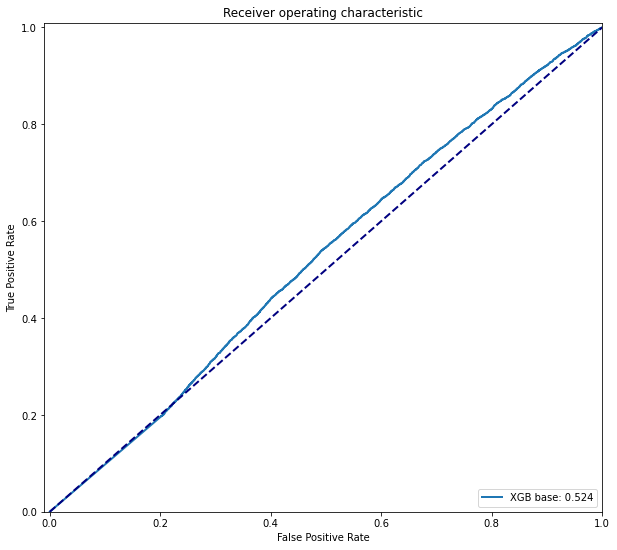

In [20]:
res2plot = []
true = df[target].sort_index()

for result in [modelXGB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

In [21]:
def plotPrRecall(true, pred):
    # Liczymy punkty potrzebne do narysowania krzywej
    precisionYes, recallYes, thresholdsYes = precision_recall_curve(true, pred)
    average_precisionYes = np.round(average_precision_score(true, pred), 4)

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(5,4.5))

    # Rysujemy krzywą PR-Recall
    ax.plot(recallYes, precisionYes, color='r', lw=2, label=f'PR curve: {average_precisionYes}')

    ax.fill_between(recallYes, precisionYes, alpha=0.25, color='b')

    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([0, 1])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc="lower left")
    plt.show()

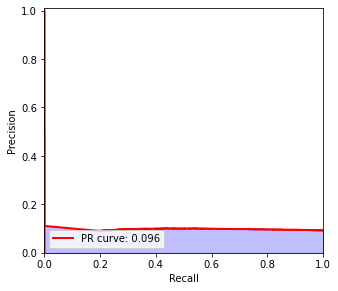

In [23]:
plotPrRecall(true, pred)

In [24]:
def CVTestXGB_under(nFolds = 5, randomState=2020, features=None, sampling_strategy='auto', debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do undersamplingu
    rus = RandomUnderSampler(random_state=42, replacement=True, sampling_strategy=sampling_strategy)

    for train, test in kf.split(df.index.values):
        # Under sampling zbioru treningowego 
        x_rus, y_rus = rus.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_rus = pd.concat([x_rus, y_rus], axis=1)
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_rus, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_rus[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [31]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_under(features=features, max_depth=12, lambdaX=366, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

(0.7804143380055946, 0.5374655978170686)

In [32]:
modelXGB_under = {
    "name":"XGB under",
    "description":"Model XGB z undersamplingiem",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

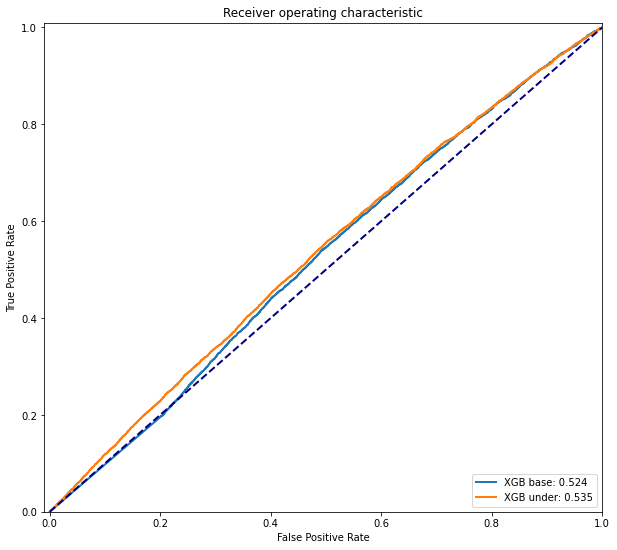

In [33]:
res2plot = []
true = df[target].sort_index()

for result in [modelXGB, modelXGB_under]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

## Zadanie 2.

Wczytaj zbiór `CompanyBankruptcyPred.csv`. Sprawdź czy da się poprawić wyniki modelowania różnymi technikami resamplingu.

Źródło danych: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction